In [1]:
# 라이브러리 임포트

import os
import glob
import gc
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib.image import imread
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.applications import VGG16, MobileNetV2
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# 드라이브 마운트 후, 데이터셋 압축 해제
from google.colab import drive
drive.mount('/content/drive')

#압축해제
import zipfile

zip_file = zipfile.ZipFile('/content/drive/MyDrive/kaggle/patato-plant-disease.zip', 'r')
extract_dir = 'potato-plant-disease'
zip_file.extractall(extract_dir)

# 원본 이미지 경로 로딩
healthy_dir = glob.glob("potato-plant-disease/PlantVillage/PlantVillage/Potato___healthy/*")
late_blight_dir =  glob.glob("potato-plant-disease/PlantVillage/PlantVillage/Potato___Late_blight/*")
early_blight_dir =  glob.glob("potato-plant-disease/PlantVillage/PlantVillage/Potato___Early_blight/*")



# 전체 이미지 리스트를 (경로, 클래스명) 형태로 합치기
image_list = [(path, 'healthy') for path in healthy_dir] + \
             [(path, 'late') for path in late_blight_dir] + \
             [(path, 'early') for path in early_blight_dir]


def split_data(image_list_with_labels, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    image_paths = [x[0] for x in image_list_with_labels]
    labels = [x[1] for x in image_list_with_labels]

    # train vs temp(val+test)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=(1 - train_ratio), stratify=labels, random_state=seed
    )

    # val vs test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=(1 - val_ratio_adjusted), stratify=temp_labels, random_state=seed
    )

    # 다시 묶어서 반환
    train = list(zip(train_paths, train_labels))
    val = list(zip(val_paths, val_labels))
    test = list(zip(test_paths, test_labels))

    return train, val, test

train, val, test = split_data(image_list)



print("[Train] ", Counter([label for _, label in train]))
print("[Val]   ", Counter([label for _, label in val]))
print("[Test]  ", Counter([label for _, label in test]))

def move_file(file_label_list, destination_root):
    for file_path, label in file_label_list:
        label_folder = os.path.join(destination_root, label)
        os.makedirs(label_folder, exist_ok=True)
        shutil.copy(file_path, os.path.join(label_folder, os.path.basename(file_path)))

# 이동
move_file(train, '/content/train')
move_file(val, '/content/val')
move_file(test, '/content/test')
healthy_src = '/content/train/healthy'
healthy_dst = '/content/train_augmented/healthy'

# Early, Late는 그대로 복사
for label in ['early', 'late']:
    shutil.copytree(f'/content/train/{label}', f'/content/train_augmented/{label}', dirs_exist_ok=True)

# Healthy 증강
os.makedirs(healthy_dst, exist_ok=True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

healthy_imgs = os.listdir(healthy_src)

for img in healthy_imgs:
    img_path = os.path.join(healthy_src, img)
    x = img_to_array(load_img(img_path, target_size=(224, 224)))
    x = x.reshape((1,) + x.shape)

    # 5개씩 생성
    i = 0
    for batch in aug.flow(x, batch_size=1, save_to_dir=healthy_dst, save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= 5:
            break
    # 원본도 복사
    shutil.copy(img_path, os.path.join(healthy_dst, os.path.basename(img)))

# 데이터 셋 분류
train_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(
    '/content/train_augmented', target_size=(224, 224), batch_size=64, class_mode='sparse'
)
val_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(
    '/content/val', target_size=(224, 224), batch_size=64, class_mode='sparse'
)
test_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(
    '/content/test', target_size=(224, 224), batch_size=64, class_mode='sparse', shuffle=False
)


Mounted at /content/drive
[Train]  Counter({'early': 800, 'late': 800, 'healthy': 121})
[Val]    Counter({'late': 100, 'early': 100, 'healthy': 15})
[Test]   Counter({'late': 100, 'early': 100, 'healthy': 16})
Found 2306 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 216 images belonging to 3 classes.


In [2]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

class LrTracker(Callback):
    def __init__(self):
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        lr = float(K.get_value(self.model.optimizer.learning_rate))
        self.history.append(lr)


In [15]:
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization

def build_model(input_shape=(224, 224, 3), num_classes=3):
    #base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    lr_schedule = CosineDecay(initial_learning_rate=0.001, decay_steps=100, alpha=0.0001)
    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


model = build_model()
lr_tracker = LrTracker()

# Step 1: freeze된 상태로 학습
history = model.fit(train_gen, validation_data=val_gen, epochs=5,
          callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),lr_tracker])

# Step 2: fine-tuning
base_model = model.layers[1]  # Sequential이 아니므로 두 번째 레이어 = base_model
for layer in base_model.layers[-20:]:
    layer.trainable = True

fine_tune_schedule = CosineDecay(1e-4, 50, alpha=1e-4)
model.compile(optimizer=Adam(learning_rate=fine_tune_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
val_loss, val_acc = model.evaluate(val_gen)
test_loss, test_acc = model.evaluate(test_gen)
history2 = model.fit(train_gen, validation_data=val_gen, epochs=10,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),lr_tracker])


Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.8587 - loss: 0.3738 - val_accuracy: 0.4651 - val_loss: 1.1171
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9511 - loss: 0.1321 - val_accuracy: 0.4930 - val_loss: 0.7784
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9560 - loss: 0.1063 - val_accuracy: 0.5860 - val_loss: 0.6514
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9583 - loss: 0.1074 - val_accuracy: 0.7070 - val_loss: 0.5479
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9648 - loss: 0.1081 - val_accuracy: 0.8233 - val_loss: 0.4598
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.8184 - loss: 0.4597
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.9050 - loss: 0.3244
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 569ms/step - accuracy: 0.9196 - loss: 0.2386 - val_accuracy: 0.4605 - val_loss: 2.8667
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 489ms/step - accuracy: 0.9919 - loss: 0.0319 - 

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,542,410 (169.92 MB)

 Trainable params: 14,847,299 (56.64 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 29,694,599 (113.28 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step


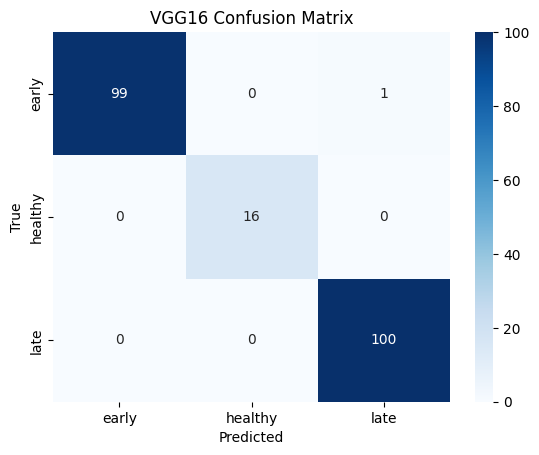

              precision    recall  f1-score   support

       early       1.00      0.99      0.99       100
     healthy       1.00      1.00      1.00        16
        late       0.99      1.00      1.00       100

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

[Train]  Counter({'early': 800, 'late': 800, 'healthy': 121})
[Val]    Counter({'late': 100, 'early': 100, 'healthy': 15})
[Test]   Counter({'late': 100, 'early': 100, 'healthy': 16})


In [17]:
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Report
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))



print("[Train] ", Counter([label for _, label in train]))
print("[Val]   ", Counter([label for _, label in val]))
print("[Test]  ", Counter([label for _, label in test]))


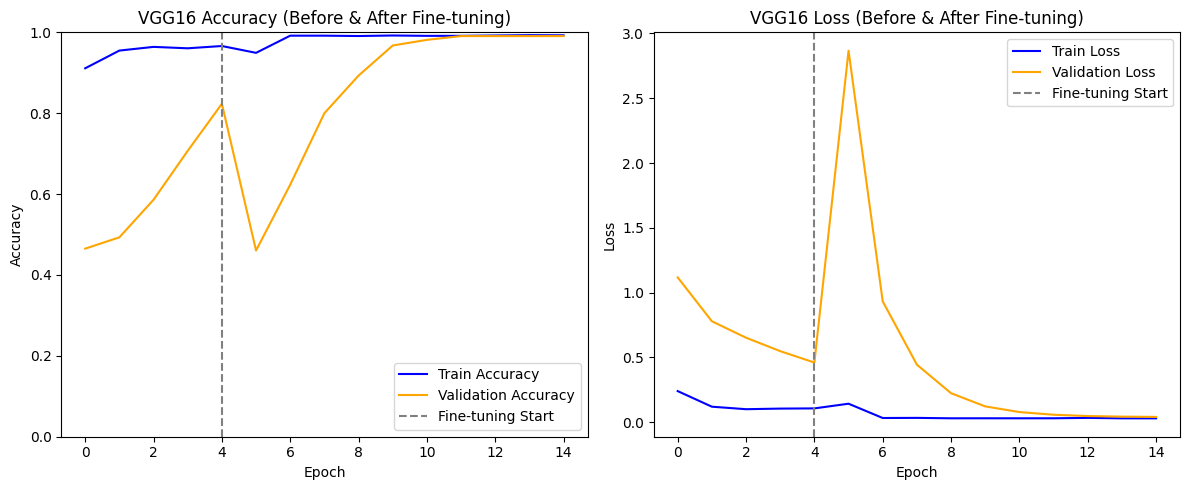

In [19]:
# 학습 정보 병합
full_acc = history.history['accuracy'] + history2.history['accuracy']
full_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']
full_loss = history.history['loss'] + history2.history['loss']
full_val_loss = history.history['val_loss'] + history2.history['val_loss']

tune_start = len(history.history['accuracy'])  # 튜닝 시작 epoch

plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(full_acc, label='Train Accuracy', color='blue')
plt.plot(full_val_acc, label='Validation Accuracy', color='orange')
plt.axvline(x=tune_start-1, color='gray', linestyle='--', label='Fine-tuning Start')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('VGG16 Accuracy (Before & After Fine-tuning)')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(full_loss, label='Train Loss', color='blue')
plt.plot(full_val_loss, label='Validation Loss', color='orange')
plt.axvline(x=tune_start-1, color='gray', linestyle='--', label='Fine-tuning Start')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16 Loss (Before & After Fine-tuning)')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:

loss_res, accuracy_res = model.evaluate(val_gen)

print(f"VGG16 accuracy : {accuracy_res*100:.2f}%")
print(f"VGG16 loss : {loss_res*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9952 - loss: 0.0355
VGG16 accuracy : 99.07%
VGG16 loss : 4.01%


### 실 데이터 분류 테스트

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스 매핑 (모델 훈련 순서 기준으로 수정 가능)
class_indices = {'early': 0, 'healthy': 1, 'late': 2}
idx_to_class = {v: k for k, v in class_indices.items()}

print(class_indices)

# 이미지 전처리 함수
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img  # 전처리 이미지, 원본 PIL 이미지 함께 반환

# 예측 + 시각화
def predict_and_show(model, image_path):
    img_array, pil_image = preprocess_image(image_path)

    pred = model.predict(img_array)
    pred_idx = np.argmax(pred)
    label = idx_to_class[pred_idx]
    confidence = np.max(pred)

    # 시각화
    plt.figure(figsize=( 2, 2))
    plt.imshow(pil_image)
    plt.axis('off')
    print(f"{path} → 예측: {label}({pred_idx}) ({confidence:.2f}) ")
    plt.show()





{'early': 0, 'healthy': 1, 'late': 2}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
/content/my_leaf_images/early_p.jpg → 예측: early(0) (1.00) 


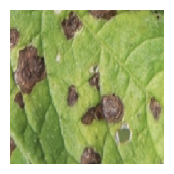

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
/content/my_leaf_images/healthy_plant.jpg → 예측: early(0) (1.00) 


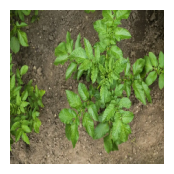

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
/content/my_leaf_images/early.jpg → 예측: early(0) (1.00) 


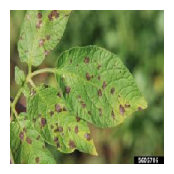

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
/content/my_leaf_images/healthy.jpg → 예측: healthy(1) (1.00) 


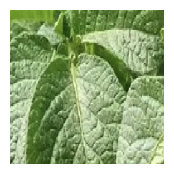

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
/content/my_leaf_images/early_blight.jpg → 예측: early(0) (1.00) 


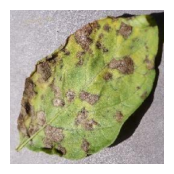

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
/content/my_leaf_images/late_blight.jpg → 예측: late(2) (0.65) 


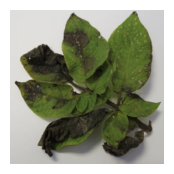

In [27]:

import glob

image_paths = glob.glob("/content/my_leaf_images/*.jpg")

for path in image_paths:
    predict_and_show(model, path)


### DB 연동

In [32]:
import sqlite3
import datetime

# DB 연결 (없으면 자동 생성)
conn = sqlite3.connect('model_info.db')
cursor = conn.cursor()

# 모델 정보 테이블
cursor.execute("""
CREATE TABLE IF NOT EXISTS models (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT,
    mode TEXT,
    total_params INTEGER,
    trainable_params INTEGER,
    non_trainable_params INTEGER,
    created_at DATETIME
)
""")

# 모델 레이어 정보
cursor.execute("""
CREATE TABLE IF NOT EXISTS model_layers (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    model_id INTEGER,
    layer_name TEXT,
    output_shape TEXT,
    num_params INTEGER,
    trainable BOOLEAN,
    FOREIGN KEY(model_id) REFERENCES models(id)
)
""")
conn.commit()


# 학습 로그 테이블
cursor.execute("""
CREATE TABLE IF NOT EXISTS training_logs (
    model_id INTEGER,
    epoch INTEGER,
    train_acc REAL,
    val_acc REAL,
    train_loss REAL,
    val_loss REAL,
    learning_rate REAL,
    PRIMARY KEY(model_id, epoch),
    FOREIGN KEY(model_id) REFERENCES models(id)
)
""")
conn.commit()


In [33]:
from tensorflow.keras import backend as K
import math

def truncate6(x):
    return math.floor(x * 1e6) / 1e6

def save_model_and_logs_to_db(model_name, mode, model_obj, history_dict, learning_rates=None):
    # 모델 메타 정보 추출
    total_params = model_obj.count_params()
    trainable_params = int(np.sum([K.count_params(w) for w in model_obj.trainable_weights]))
    non_trainable_params = int(np.sum([K.count_params(w) for w in model_obj.non_trainable_weights]))
    created_at = datetime.datetime.now()

    # 모델 정보 저장
    cursor.execute("""
        INSERT INTO models (name, mode, total_params, trainable_params, non_trainable_params, created_at)
        VALUES (?, ?, ?, ?, ?, ?)
    """, (model_name, mode, total_params, trainable_params, non_trainable_params, created_at))
    model_id = cursor.lastrowid

    # 레이어 정보 저장
    for layer in model_obj.layers:
        layer_name = layer.name
        output_shape = str(layer.output_shape) if hasattr(layer, 'output_shape') else 'unknown'
        num_params = layer.count_params() if hasattr(layer, 'count_params') else 0
        trainable = bool(layer.trainable)

        cursor.execute("""
            INSERT INTO model_layers (model_id, layer_name, output_shape, num_params, trainable)
            VALUES (?, ?, ?, ?, ?)
        """, (model_id, layer_name, output_shape, num_params, trainable))

    # 학습 로그 저장 (복합 PK: model_id + epoch)
    for epoch in range(len(history_dict['accuracy'])):
        lr = learning_rates[epoch] if learning_rates else None
        cursor.execute("""
            INSERT INTO training_logs (model_id, epoch, train_acc, val_acc, train_loss, val_loss, learning_rate)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (
            model_id, epoch,
            truncate6(history_dict['accuracy'][epoch]),
            truncate6(history_dict['val_accuracy'][epoch]),
            truncate6(history_dict['loss'][epoch]),
            truncate6(history_dict['val_loss'][epoch]),
            truncate6(lr) if lr is not None else None
        ))

    conn.commit()
    print(f"모델 '{model_name} ({mode})' 및 로그 저장 완료 (ID={model_id})")


In [34]:
# 학습 이력 병합
full_history = {}
for key in history.history:
    full_history[key] = history.history[key] + history2.history[key]

# 학습률 리스트 추출
learning_rates = lr_tracker.history

#  모델 저장 후 기록
save_model_and_logs_to_db(
    model_name="VGG16",
    mode="augmented",
    model_obj=model,
    history_dict=full_history,   # pre_history + fine_tune_history 합친 딕셔너리
    learning_rates=lr_tracker.history if 'lr_tracker' in globals() else None
)



모델 'VGG16 (augmented)' 및 로그 저장 완료 (ID=1)


In [35]:
print("모델 확인")
# 모델 목록 확인
cursor.execute("SELECT * FROM models")

for row in cursor.fetchall():
    print(row)

print("학습 로그 확인")
# 모델의 학습 로그 확인
model_id = 1
cursor.execute("SELECT * FROM training_logs WHERE model_id = ?", (model_id,))
for row in cursor.fetchall():
    print(row)

print("레이어 확인")
# 모델의 레이어 정보 확인
cursor.execute("SELECT * FROM model_layers WHERE model_id = ?", (model_id,))
for row in cursor.fetchall():
    print(row)


모델 확인
(1, 'VGG16', 'augmented', 14847811, 14847299, 512, '2025-03-29 14:22:01.417449')
학습 로그 확인
(1, 0, 0.911101, 0.465116, 0.239446, 1.117092, 0.000698)
(1, 1, 0.9549, 0.493023, 0.119042, 0.778444, 0.000157)
(1, 2, 0.964006, 0.586046, 0.09967, 0.651445, 0.0)
(1, 3, 0.960537, 0.706976, 0.104348, 0.547886, 0.0)
(1, 4, 0.966175, 0.823255, 0.105882, 0.459757, 0.0)
(1, 5, 0.949262, 0.460465, 0.142038, 2.8667, 1.5e-05)
(1, 6, 0.99176, 0.623255, 0.031748, 0.931973, 0.0)
(1, 7, 0.99176, 0.8, 0.032678, 0.443537, 0.0)
(1, 8, 0.990893, 0.893023, 0.029408, 0.222941, 0.0)
(1, 9, 0.992194, 0.967441, 0.029633, 0.12131, 0.0)
(1, 10, 0.991326, 0.981395, 0.029441, 0.077524, 0.0)
(1, 11, 0.991326, 0.990697, 0.029612, 0.05694, 0.0)
(1, 12, 0.992194, 0.990697, 0.032649, 0.046808, 0.0)
(1, 13, 0.993061, 0.990697, 0.029123, 0.042325, 0.0)
(1, 14, 0.992627, 0.990697, 0.029157, 0.040064, 0.0)
레이어 확인
(1, 1, 'input_layer_3', 'unknown', 0, 1)
(2, 1, 'vgg16', '(None, 7, 7, 512)', 14714688, 0)
(3, 1, 'global_averag